## HW2
#### Due Mar. 18th by end of day. Name your notebook as firstname.lastname.HW2.ipynb and email it to zhang@csc.lsu.edu

Your tasks in this homework are to experiment with CNN.
A simple CNN is given below. 

### Task 1
Train the CNN (as much as you can) to reach convergence. Investigate what patterns the first layer (layer 0) filters pick up by plotting the filters as small 2d images. To plot a 2d array x as image, use "imshow(x, cmap=cm.gray)". You should plot the 10 filters together using subplot. 

### Task 2
The given CNN has 2 conv&pool layers, 1 hidden layer and 1 output layer. 
Modify the CNN to have:
  - 1 conv&pool layer, 1 hidden layer and 1 output layer;
  - 1 hidden layer and 1 output layer; 
  
while keeping the other parameters the same. Compare the error rates on the test data for the original CNN and the two modifications and determine whether the conv&pool layers play a significant role for performance.

### Task 3
Change the number of filters for the two conv&pool layers:
  - try 10 filters for layer 1 and 20 for layer 2;
  - try 20 filters for layer 1 and 10 for layer 2.

Compare error rate of the two cases and that of the original. Comment on how number of filters can impact performance. 

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import cPickle, gzip

import numpy

import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv

## Hidden Layer and Output Layer

In [5]:
class HiddenLayer(object):

    def __init__(self, input, n_in, n_out):
        self.input = input

        W_values = 4*numpy.random.uniform(
                low=-numpy.sqrt(6. / (n_in + n_out)),
                high=numpy.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )
        self.W = theano.shared(value=W_values, name='W', borrow=True)
        self.b = theano.shared(value=numpy.zeros((n_out,)), name='b', borrow=True)
        self.params = [self.W, self.b]

        net = T.dot(self.input, self.W) + self.b
        self.output = T.nnet.sigmoid(net)

        
class MultiLogisticRegression(object):

    def __init__(self, input, n_in, n_out):

        self.input = input

        self.W = theano.shared(
            value=numpy.zeros((n_in, n_out)),
            name='W',
            borrow=True
        )
        self.b = theano.shared(
            value = numpy.zeros((n_out,)),
            name='b',
            borrow=True
        )
        self.params = [self.W, self.b]

        self.prob = T.nnet.softmax(T.dot(self.input, self.W) + self.b)
        self.predict = T.argmax(self.prob, axis=1)

    def nll(self, y):
        return  -T.mean(T.log(self.prob)[T.arange(y.shape[0]), y])


## Conv + Pool Layer
### output size = (imagesize - filtersize + 1)/poolsize

In [6]:
class ConvPoolLayer(object):

    def __init__(self, input, filter_shape, image_shape, poolsize):

        self.input = input

        n_in = filter_shape[1]*filter_shape[2]*filter_shape[3]
        n_out = (filter_shape[0]*filter_shape[2]*filter_shape[3])/(poolsize[0]*poolsize[1])
        W_bound = numpy.sqrt(6./(n_in + n_out))
        self.W = theano.shared(
            numpy.random.uniform(low=-W_bound, high=W_bound, size=filter_shape),
            borrow=True
        )
        self.b = theano.shared(value=numpy.zeros((filter_shape[0],)), borrow=True)
        self.params = [self.W, self.b]
        
        conv_out = conv.conv2d(
            input=self.input,
            filters=self.W,
            filter_shape=filter_shape,
            image_shape=image_shape
        )

        pooled_out = downsample.max_pool_2d(
            input=conv_out,
            ds=poolsize,
            ignore_border=True
        )

        self.output = T.tanh(pooled_out + self.b.dimshuffle('x', 0, 'x', 'x'))


## TASK 1 


<type 'numpy.ndarray'>
[[ 0.22549739  0.06883609 -0.14388045 -0.23659528 -0.04452471]
 [ 0.22542574  0.19469994  0.1069187   0.19904089  0.14812224]
 [ 0.24288173 -0.05328788  0.1259925   0.19045583 -0.00962825]
 [ 0.01379085 -0.21537933 -0.09660139  0.17150259 -0.0209229 ]
 [ 0.13490995  0.06167933  0.19279594  0.17113649 -0.19478226]]


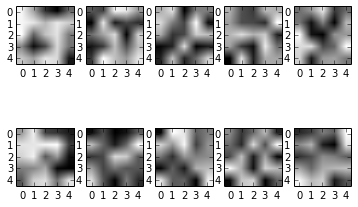

In [69]:
batch_size = 250
learning_rate=0.1
nkerns=[10, 10]


x = T.matrix('x')
y = T.ivector('y')


layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

#layer0_output = layer0.output.flatten(2)

filters = layer0.W
#print filters.shape()
filters_value = (filters.get_value())
print type(filters_value)
#print filters_value[0, 0, :, :]
print filters_value[0][0]
#print filters_value[1][0]
import pylab
#imshow(filters_value[0][0],cmap=cm.gray)     
#img_ = img.transpose(2, 0, 1).reshape(1, 3, 639, 516)
#filtered_img = f(img_)

# plot original image and first and second components of output
#pylab.subplot(1, 3, 1); pylab.axis('off'); pylab.imshow(img)
#pylab.gray();
# recall that the convOp output (filtered image) is actually a "minibatch",
# of size 1 here, so we take index 0 in the first dimension:
#pylab.subplot(1, 3, 2); pylab.axis('off'); pylab.imshow(filtered_img[0, 0, :, :])
pylab.subplot(2, 5, 1); imshow(filters_value[0][0],cmap=cm.gray) 
pylab.subplot(2, 5, 2); imshow(filters_value[1][0],cmap=cm.gray)   
pylab.subplot(2, 5, 3); imshow(filters_value[2][0],cmap=cm.gray) 
pylab.subplot(2, 5, 4); imshow(filters_value[3][0],cmap=cm.gray) 
pylab.subplot(2, 5, 5); imshow(filters_value[4][0],cmap=cm.gray) 
pylab.subplot(2, 5, 6); imshow(filters_value[5][0],cmap=cm.gray) 
pylab.subplot(2, 5, 7); imshow(filters_value[6][0],cmap=cm.gray)   
pylab.subplot(2, 5, 8); imshow(filters_value[7][0],cmap=cm.gray) 
pylab.subplot(2, 5, 9); imshow(filters_value[8][0],cmap=cm.gray) 
pylab.subplot(2, 5, 10); imshow(filters_value[9][0],cmap=cm.gray) 
#pylab.imshow(filters_value[0, 0, :, :])
#pylab.imshow(filters_value[0, 1, :, :])
#pylab.show()

## TASK 2
## Comments
As the Layers decrease, the error rate will increase. The CONV&Pool layers play a significant role for performance.
For 4 layers, the error rate is 0.0383;
For 3 layers, the error rate is 0.058;
For 2 layers, the error rate is 0.0906.

## Making ConvNN

In [7]:
#oringal 
batch_size = 250
learning_rate=0.1
nkerns=[10, 10]


x = T.matrix('x')
y = T.ivector('y')


layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

layer1 = ConvPoolLayer(
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 12, 12),
    filter_shape=(nkerns[1], nkerns[0], 5, 5),
    poolsize=(2, 2)
)
layer1_output = layer1.output.flatten(2)

layer2 = HiddenLayer(
    input=layer1_output,
    n_in=nkerns[1]*4*4,
    n_out=50,
)

layer3 = MultiLogisticRegression(input=layer2.output, n_in=50, n_out=10)


cost = layer3.nll(y)


model_predict = theano.function(
    [x],
    layer3.predict
)


params = layer3.params + layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

## Train and Test

In [12]:
dataset = 'digits.pkl.gz' 
f = gzip.open(dataset, 'rb')
train_set, valid_set, test_set = cPickle.load(f)
f.close()
train_set_x, train_set_y = train_set
test_set_x, test_set_y = test_set
train_set_y = train_set_y.astype(numpy.int32)

ix = []
for i in range(10):
    ix.append(numpy.nonzero(train_set_y == i)[0][:500])
ix = numpy.concatenate(ix)
train_set_x = train_set_x[ix]
train_set_y = train_set_y[ix]
ix = numpy.random.permutation(train_set_x.shape[0])
train_set_x = train_set_x[ix]
train_set_y = train_set_y[ix]

n_batches = train_set_x.shape[0]
n_batches /= batch_size

In [13]:
n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

iteration: 0 , nll = 45.4303015302
iteration: 1 , nll = 43.7341293077
iteration: 2 , nll = 41.2280998972
iteration: 3 , nll = 37.7799647444
iteration: 4 , nll = 33.7595572423
iteration: 5 , nll = 29.7385993869
iteration: 6 , nll = 26.1265857632
iteration: 7 , nll = 23.0730963909
iteration: 8 , nll = 20.5583297456
iteration: 9 , nll = 18.5006839132
iteration: 10 , nll = 16.8116210827
iteration: 11 , nll = 15.4144894157
iteration: 12 , nll = 14.2480744455
iteration: 13 , nll = 13.2639833407
iteration: 14 , nll = 12.4246744678
iteration: 15 , nll = 11.7015850694
iteration: 16 , nll = 11.0727088729
iteration: 17 , nll = 10.5210879339
iteration: 18 , nll = 10.0336418303
iteration: 19 , nll = 9.59993980107
iteration: 20 , nll = 9.21167746167
iteration: 21 , nll = 8.86223764259
iteration: 22 , nll = 8.54613319857
iteration: 23 , nll = 8.25879105253
iteration: 24 , nll = 7.99651883325
iteration: 25 , nll = 7.75614276122
iteration: 26 , nll = 7.53491924372
iteration: 27 , nll = 7.33060456875
it

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


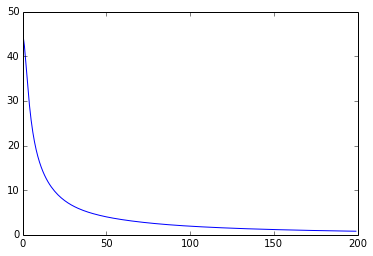

In [10]:
%pylab inline
plot(c)

In [11]:
n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

origal_err = 1.0*err/len(test_set_y)
print origal_err

0.0383


# 1 conv&pool layer, 1 hidden layer and 1 output layer

iteration: 0 , nll = 45.2698378147
iteration: 1 , nll = 43.2467339604
iteration: 2 , nll = 40.4667179599
iteration: 3 , nll = 36.9244004485
iteration: 4 , nll = 33.0431569162
iteration: 5 , nll = 29.2784220162
iteration: 6 , nll = 25.9111224237
iteration: 7 , nll = 23.0408356725
iteration: 8 , nll = 20.6532830744
iteration: 9 , nll = 18.683701332
iteration: 10 , nll = 17.0567484961
iteration: 11 , nll = 15.7040079418
iteration: 12 , nll = 14.568651712
iteration: 13 , nll = 13.6056227066
iteration: 14 , nll = 12.779587842
iteration: 15 , nll = 12.0637736947
iteration: 16 , nll = 11.4376118004
iteration: 17 , nll = 10.8853503713
iteration: 18 , nll = 10.3949244081
iteration: 19 , nll = 9.95683934814
iteration: 20 , nll = 9.56347913761
iteration: 21 , nll = 9.20870127643
iteration: 22 , nll = 8.88721185927
iteration: 23 , nll = 8.59472569189
iteration: 24 , nll = 8.32754743712
iteration: 25 , nll = 8.08263755058
iteration: 26 , nll = 7.85728730463
iteration: 27 , nll = 7.64919534049
itera

`%matplotlib` prevents importing * from pylab and numpy


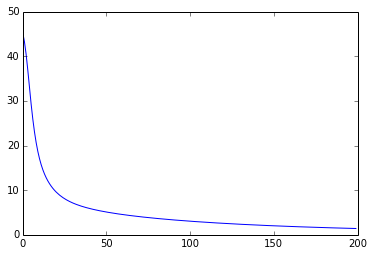

In [14]:
#1 conv&pool layer, 1 hidden layer and 1 output layer
batch_size = 250
learning_rate=0.1
nkerns=[10, 10]


x = T.matrix('x')
y = T.ivector('y')

#output size = (imagesize - filtersize + 1)/poolsize
layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)
layer0_output = layer0.output.flatten(2)

layer1 = HiddenLayer(
    input=layer0_output, #layer1_output,
    n_in=nkerns[0]*12*12,
    n_out=50,
)

layer2 = MultiLogisticRegression(input=layer1.output, n_in=50, n_out=10)


cost = layer2.nll(y)


model_predict = theano.function(
    [x],
    layer2.predict
)


params = layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

#train and test

n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

%pylab inline
plot(c)    
    
n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

print 1.0*err/len(test_set_y)    

## 1 hidden layer and 1 output layer

iteration: 0 , nll = 45.1851813375
iteration: 1 , nll = 43.2761391929
iteration: 2 , nll = 41.314718834
iteration: 3 , nll = 39.2410767521
iteration: 4 , nll = 37.0525644448
iteration: 5 , nll = 34.796328858
iteration: 6 , nll = 32.545576954
iteration: 7 , nll = 30.3727086827
iteration: 8 , nll = 28.3317249084
iteration: 9 , nll = 26.4536393434
iteration: 10 , nll = 24.7501014161
iteration: 11 , nll = 23.2193792756
iteration: 12 , nll = 21.8516758689
iteration: 13 , nll = 20.6330056068
iteration: 14 , nll = 19.5477669062
iteration: 15 , nll = 18.5803423601
iteration: 16 , nll = 17.716022555
iteration: 17 , nll = 16.9414744322
iteration: 18 , nll = 16.2449136621
iteration: 19 , nll = 15.6160960715
iteration: 20 , nll = 15.04620923
iteration: 21 , nll = 14.5277182835
iteration: 22 , nll = 14.0541993486
iteration: 23 , nll = 13.6201790277
iteration: 24 , nll = 13.220989013
iteration: 25 , nll = 12.8526390158
iteration: 26 , nll = 12.5117081359
iteration: 27 , nll = 12.195253254
iteration:

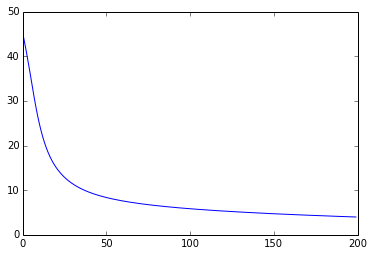

In [17]:
batch_size = 250
learning_rate=0.1
nkerns=[10, 10]


x = T.matrix('x')
y = T.ivector('y')

#output size = (imagesize - filtersize + 1)/poolsize
layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0_output = T.flatten(layer0_input, 2)

layer0 = HiddenLayer(
    input=layer0_output, 
    n_in=28*28,
    n_out=50,
)

layer1 = MultiLogisticRegression(input=layer0.output, n_in=50, n_out=10)


cost = layer1.nll(y)


model_predict = theano.function(
    [x],
    layer1.predict
)


params = layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

#train and test

n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

%pylab inline
plot(c)    
    
n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

modified2_err = 1.0*err/len(test_set_y)  
print modified2_err


## TASK 3
## COMMENTS
For nkerns=[10, 10], error rate is 0.383
For nkerns=[10, 20], error rate is 0.344
For nkerns=[20, 10], error rate is 0.341
The error rate shows that, the best performance is [20, 10], which means that increasing the first filters of layer 1 will increase the performance.

iteration: 0 , nll = 45.1434715188
iteration: 1 , nll = 41.825062752
iteration: 2 , nll = 36.5941568298
iteration: 3 , nll = 31.2008102544
iteration: 4 , nll = 26.641358497
iteration: 5 , nll = 23.0454139933
iteration: 6 , nll = 20.2343738587
iteration: 7 , nll = 18.0079156119
iteration: 8 , nll = 16.2158664015
iteration: 9 , nll = 14.7494068433
iteration: 10 , nll = 13.5310122818
iteration: 11 , nll = 12.507929214
iteration: 12 , nll = 11.6388464988
iteration: 13 , nll = 10.8911073658
iteration: 14 , nll = 10.2419936736
iteration: 15 , nll = 9.67250306809
iteration: 16 , nll = 9.16830230581
iteration: 17 , nll = 8.71779988191
iteration: 18 , nll = 8.31234462075
iteration: 19 , nll = 7.94553803427
iteration: 20 , nll = 7.61160658226
iteration: 21 , nll = 7.30610844795
iteration: 22 , nll = 7.02557471901
iteration: 23 , nll = 6.76646978091
iteration: 24 , nll = 6.52608981277
iteration: 25 , nll = 6.30298955845
iteration: 26 , nll = 6.09458514965
iteration: 27 , nll = 5.89900193134
itera

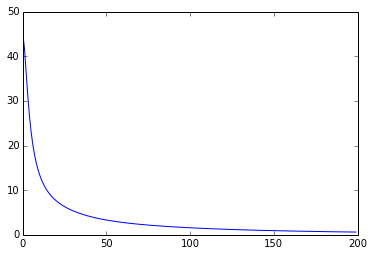

In [18]:
##try 10 filters for layer 1 and 20 for layer 2. 
batch_size = 250
learning_rate=0.1
nkerns=[10, 20]


x = T.matrix('x')
y = T.ivector('y')


layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

layer1 = ConvPoolLayer(
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 12, 12),
    filter_shape=(nkerns[1], nkerns[0], 5, 5),
    poolsize=(2, 2)
)
layer1_output = layer1.output.flatten(2)

layer2 = HiddenLayer(
    input=layer1_output,
    n_in=nkerns[1]*4*4,
    n_out=50,
)

layer3 = MultiLogisticRegression(input=layer2.output, n_in=50, n_out=10)


cost = layer3.nll(y)


model_predict = theano.function(
    [x],
    layer3.predict
)


params = layer3.params + layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

#train and test

n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

%pylab inline
plot(c)  

n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

err_value = 1.0*err/len(test_set_y)
print err_value

iteration: 0 , nll = 45.5128140578
iteration: 1 , nll = 42.8108926587
iteration: 2 , nll = 37.80908574
iteration: 3 , nll = 32.3470240431
iteration: 4 , nll = 27.6076012325
iteration: 5 , nll = 23.8427912227
iteration: 6 , nll = 20.9320664267
iteration: 7 , nll = 18.6729436441
iteration: 8 , nll = 16.8855444693
iteration: 9 , nll = 15.4389401965
iteration: 10 , nll = 14.2404714296
iteration: 11 , nll = 13.2291406867
iteration: 12 , nll = 12.3614151582
iteration: 13 , nll = 11.604663986
iteration: 14 , nll = 10.9393612709
iteration: 15 , nll = 10.3483554997
iteration: 16 , nll = 9.81838069319
iteration: 17 , nll = 9.33872803223
iteration: 18 , nll = 8.90308822179
iteration: 19 , nll = 8.50555373476
iteration: 20 , nll = 8.14161310686
iteration: 21 , nll = 7.80613049583
iteration: 22 , nll = 7.49638790342
iteration: 23 , nll = 7.20935496962
iteration: 24 , nll = 6.94238652344
iteration: 25 , nll = 6.69254327518
iteration: 26 , nll = 6.45885526824
iteration: 27 , nll = 6.24060089483
itera

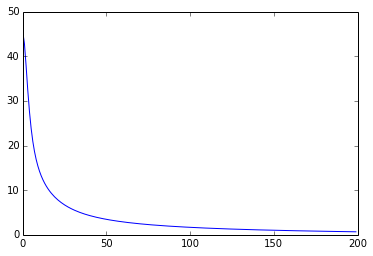

In [19]:
#try 20 filters for layer 1 and 10 for layer 2.
batch_size = 250
learning_rate=0.1
nkerns=[20, 10]


x = T.matrix('x')
y = T.ivector('y')


layer0_input = x.reshape((batch_size, 1, 28, 28))
layer0 = ConvPoolLayer(
    input=layer0_input,
    image_shape=(batch_size, 1, 28, 28),
    filter_shape=(nkerns[0], 1, 5, 5),
    poolsize=(2, 2)
)

layer1 = ConvPoolLayer(
    input=layer0.output,
    image_shape=(batch_size, nkerns[0], 12, 12),
    filter_shape=(nkerns[1], nkerns[0], 5, 5),
    poolsize=(2, 2)
)
layer1_output = layer1.output.flatten(2)

layer2 = HiddenLayer(
    input=layer1_output,
    n_in=nkerns[1]*4*4,
    n_out=50,
)

layer3 = MultiLogisticRegression(input=layer2.output, n_in=50, n_out=10)


cost = layer3.nll(y)


model_predict = theano.function(
    [x],
    layer3.predict
)


params = layer3.params + layer2.params + layer1.params + layer0.params
grads = T.grad(cost, params)
updates = [
    (param_i, param_i - learning_rate * grad_i)
    for param_i, grad_i in zip(params, grads)
]

train_model = theano.function(
    [x, y],
    cost,
    updates=updates
)

#train and test

n_epochs = 200
c = numpy.zeros((n_epochs,))
for i in range(n_epochs): 
    err = 0
    for b in range(n_batches):
        err += train_model(train_set_x[b*batch_size:(b+1)*batch_size], train_set_y[b*batch_size:(b+1)*batch_size])
    print 'iteration:', i, ', nll =', err
    c[i] = err

%pylab inline
plot(c)  

n_testbatches = test_set_x.shape[0] / batch_size
err = 0
for b in range(n_testbatches):
    yp = model_predict(test_set_x[b*batch_size:(b+1)*batch_size])
    yy = test_set_y[b*batch_size:(b+1)*batch_size]
    err += len(np.nonzero(yp - yy)[0])

err_value = 1.0*err/len(test_set_y)
print err_value